Note: Please note that Storyboard is refereed to as Galley in the code and Control as original

# Getting data for Section IV.A and Section IV.B

### Accuracy (and relevant other information)

In [38]:
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats

# statsmodels related
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.miscmodels.ordinal_model import OrderedModel

# My implementations
from analysis_utils import generate_answers, generate_original_df, generate_ordered_df, define_df_comparison, generate_df_queries, generate_df_for_analysis, get_query_generation_time, generate_model_answers_df

answers = generate_answers() # answers dataframe
original_df = generate_original_df() # retrieving the data
df_w_order = generate_ordered_df(original_df) # adding the order in which the task was given
df_compare = define_df_comparison(answers, df_w_order, scoreCal=True) # Compare the provided answer with correct answer

# This needs to be calculated here since df_w_order changes later
df_notsure_compare = define_df_comparison(answers, df_w_order, scoreCal=False) # Understand how many 'Not sure' answers were provided

df_w_order.columns = df_w_order.columns.swaplevel()
df_order = df_w_order['order']
df_w_order.columns = df_w_order.columns.swaplevel()
df_order.columns.set_names('modality', inplace=True)
df_order = df_order.stack('modality').rename('order')

modalities = ['control', 'gallery','video','text']
modalities_usability = ['control_usability', 'gallery_usability','video_usability','text_usability']

df = generate_df_for_analysis(df_compare, df_order)
df

,pid,generic_or_query,modality,qname,correct,object_or_event,qid,order,summary,cross
0,1716183785,Generic,control,object0,0,object,control_object0,3,No_Summary,C
1,1716183785,Generic,control,object1,0,object,control_object1,3,No_Summary,C
2,1716183785,Generic,control,object2,1,object,control_object2,3,No_Summary,C
3,1716183785,Generic,control,event0,0,event,control_event0,3,No_Summary,C
4,1716183785,Generic,control,event1,1,event,control_event1,3,No_Summary,C
...,...,...,...,...,...,...,...,...,...,...
715,1719270641,Query,text,object1,0,object,text_object1,2,Q,QT
716,1719270641,Query,text,object2,1,object,text_object2,2,Q,QT
717,1719270641,Query,text,event0,0,event,text_event0,2,Q,QT
718,1719270641,Query,text,event1,1,event,text_event1,2,Q,QT


## Time

In [39]:
df_time = original_df[modalities]
df_time.columns = df_time.columns.set_names('modality', level=0)
df_time = df_time.stack('modality', future_stack=True)
df_time = df_time.reset_index()[['pid','generic_or_query','modality','object_conf','event_conf','time']]
df_time

df_time = (
    df[['pid','generic_or_query','modality', 'order', 'summary','cross']]
    .merge(df_time[['pid','generic_or_query','modality','object_conf','event_conf','time']])
)
df_time.drop_duplicates(subset=['pid', 'modality'], inplace=True)


# Generating the time without the time to process queries
df_query_gentime = get_query_generation_time()

def adjust_time(row):
    """    Adjusts the 'adjusted_time' based on conditions and values from df_query_gentime    """
    if row.generic_or_query == 'Query'and row.modality != 'control':
        mod = row.modality
        gen_time = df_query_gentime[(df_query_gentime['pid'] == row['pid']) & (df_query_gentime['modality'] == mod.lower())]['query_gentime'].values[0]
        return row['adjusted_time'] - gen_time
    else:
        return row['adjusted_time']


df_time['adjusted_time'] = df_time['time'].copy()
df_time['adjusted_time'] = df_time.apply(adjust_time, axis=1)
df_time

,pid,generic_or_query,modality,order,summary,cross,object_conf,event_conf,time,adjusted_time
0,1716183785,Generic,control,3,No_Summary,C,6,6,441.896724,441.896724
6,1716183785,Generic,video,0,G,GV,8,2,598.635028,598.635028
12,1716183785,Generic,gallery,2,G,GS,5,4,211.733207,211.733207
18,1716183785,Generic,text,1,G,GT,5,7,387.382731,387.382731
24,1716876511,Generic,control,2,No_Summary,C,10,10,407.989529,407.989529
...,...,...,...,...,...,...,...,...,...,...
690,1718848877,Query,text,1,Q,QT,9,7,421.810946,261.202937
696,1719270641,Query,control,1,No_Summary,C,5,9,582.955703,582.955703
702,1719270641,Query,video,0,Q,QV,7,2,692.908609,597.137408
708,1719270641,Query,gallery,3,Q,QS,7,5,609.237441,534.905019


### Section IV.D.1: Confidence-related data

In [40]:
df_object = df_time[['pid', 'generic_or_query', 'modality', 'object_conf', 'time']].copy()
df_object['conf'] = df_object.pop('object_conf')
df_object['object_or_event'] = 'object'

df_event = df_time[['pid', 'generic_or_query', 'modality', 'event_conf', 'time']].copy()
df_event['conf'] = df_event.pop('event_conf')
df_event['object_or_event'] = 'event'

df_conf = pd.concat([df_object, df_event])
df_conf = df_conf.reset_index(drop=True)

df_conf['object_or_event'] =  pd.Categorical(df_conf['object_or_event'],  categories=['object', 'event'], ordered=False)

df_conf = (
    df[['pid','generic_or_query','modality', 'order', 'summary','cross']]
    .merge(df_conf[['pid','generic_or_query','modality','object_or_event','conf','time']])
)
df_conf = df_conf.drop_duplicates(subset=['pid','modality','object_or_event'])

df_notsure = generate_df_for_analysis(df_notsure_compare, df_order)
df_notsure.rename(columns={'correct':'not_sure'}, inplace=True)
df_notsure = df_notsure[df_notsure.not_sure.values == 0]

df_conf = pd.merge(
        df_notsure, 
        df_conf[['pid', 'generic_or_query', 'modality', 'object_or_event', 'conf']],
    )

df_conf

,pid,generic_or_query,modality,qname,not_sure,object_or_event,qid,order,summary,cross,conf
0,1716183785,Generic,control,object0,0,object,control_object0,3,No_Summary,C,6
1,1716183785,Generic,control,object1,0,object,control_object1,3,No_Summary,C,6
2,1716183785,Generic,control,object2,0,object,control_object2,3,No_Summary,C,6
3,1716183785,Generic,control,event0,0,event,control_event0,3,No_Summary,C,6
4,1716183785,Generic,control,event1,0,event,control_event1,3,No_Summary,C,6
...,...,...,...,...,...,...,...,...,...,...,...
621,1719270641,Query,text,object1,0,object,text_object1,2,Q,QT,7
622,1719270641,Query,text,object2,0,object,text_object2,2,Q,QT,7
623,1719270641,Query,text,event0,0,event,text_event0,2,Q,QT,7
624,1719270641,Query,text,event1,0,event,text_event1,2,Q,QT,7


### Section IV.D.2 Usability-related data

In [41]:
df_usability = original_df[modalities_usability]
df_usability.columns = df_usability.columns.set_names('modality', level=0)
df_usability = df_usability.stack('modality', future_stack=True)
df_usability = df_usability.reset_index()[['pid','generic_or_query','modality', 0,1,2,3,4,5,6,7,8,9,10]]

sus_items = [df_usability[i] for i in range(10)]
sus_scores = []
for i in range(10):
    if i % 2 == 0:  # Odd-numbered questions (0-based index)
        sus_scores.append(sus_items[i] - 1)
    else:  # Even-numbered questions (0-based index)
        sus_scores.append(5 - sus_items[i])
sus_total_score = sum(sus_scores)
df_usability['usability'] = sus_total_score * 2.5
df_usability['modality'] = df_usability['modality'].str.replace('_usability', '')
df_usability

df_usability = pd.merge(df_usability, df[['pid', 'generic_or_query', 'modality', 'order', 'summary','cross']], 
            on=['pid', 'generic_or_query', 'modality'], 
            how='left')

df_usability = df_usability.drop_duplicates(subset=['pid', 'generic_or_query', 'modality'])
df_usability

,pid,generic_or_query,modality,0,1,2,3,4,5,6,7,8,9,10,usability,order,summary,cross
0,1716183785,Generic,control,3,3,3,2,3,3,3,3,3,3,Empty,52.5,3,No_Summary,C
6,1716183785,Generic,gallery,3,3,3,3,2,3,3,3,2,3,Empty,45.0,2,G,GS
12,1716183785,Generic,video,3,2,3,3,3,3,3,3,2,3,Empty,50.0,0,G,GV
18,1716183785,Generic,text,2,3,2,3,3,3,3,3,2,3,Empty,42.5,1,G,GT
24,1716876511,Generic,control,4,1,5,1,4,1,4,1,5,1,Empty,92.5,2,No_Summary,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690,1718848877,Query,text,5,3,4,5,4,4,5,4,4,2,Empty,60.0,1,Q,QT
696,1719270641,Query,control,2,3,3,3,4,1,4,1,5,1,Ability to slow down as I am viewing at a cert...,72.5,1,No_Summary,C
702,1719270641,Query,gallery,2,3,2,3,2,3,4,3,3,3,Providing a confidence score for AI generated ...,45.0,3,Q,QS
708,1719270641,Query,video,5,2,4,3,1,3,4,2,3,3,HAving the option to view lengthier segments w...,60.0,0,Q,QV


### Section IV.D.3.Familiarity-related data

In [42]:
df_fam = original_df.familiarity
df_fam_cols = df_fam.columns
df_fam = df_fam.astype('int')
df_fam = df_fam.reset_index()

df_fam = pd.merge(df[['pid', 'generic_or_query', 'modality', 'order', 'summary','cross', 'correct']], df_fam,
                on=['pid', 'generic_or_query'], 
                how='left',
)
df_fam

,pid,generic_or_query,modality,order,summary,cross,correct,exp_robots,exp_envs,exp_subT,freq_robot,freq_vid,exp_vidsum,exp_intervidsum,freq_usemodels,trust_models
0,1716183785,Generic,control,3,No_Summary,C,0,2,3,3,1,2,2,2,3,3
1,1716183785,Generic,control,3,No_Summary,C,0,2,3,3,1,2,2,2,3,3
2,1716183785,Generic,control,3,No_Summary,C,1,2,3,3,1,2,2,2,3,3
3,1716183785,Generic,control,3,No_Summary,C,0,2,3,3,1,2,2,2,3,3
4,1716183785,Generic,control,3,No_Summary,C,1,2,3,3,1,2,2,2,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,1719270641,Query,text,2,Q,QT,0,2,2,3,3,4,2,2,3,3
716,1719270641,Query,text,2,Q,QT,1,2,2,3,3,4,2,2,3,3
717,1719270641,Query,text,2,Q,QT,0,2,2,3,3,4,2,2,3,3
718,1719270641,Query,text,2,Q,QT,1,2,2,3,3,4,2,2,3,3


## Analysis

The following block will run the relevant regression models based on the outcome (y)

Setting compareGQ:
* False: H1 analysis setting where summary type = [Control, G, Q]
* True: H2  analysis setting where summary type = [G, Q]

In [43]:
time_variable = 'time' # 'time' or 'adjusted_time', 'time' is the entire time for a task without accounting for the time it takes to generate a query

# TODO depending on what your dependant variable is, change the y value
# y = ['correct', time_variable, 'conf', 'usability']
y = 'time'

# TODO depending on what hypothesis you test: If H1 - this is False, if H2 - this is True
compareGQ = True

# This will map the relevant dataframe as per your analysis
df_map = {
    'correct': df,
    time_variable: df_time, 
    'conf': df_conf, 
    'usability': df_usability,
}
df_of_interest = df_map.get(y).copy()

if compareGQ:
    df_of_interest = df_of_interest[df_of_interest['summary'] != 'No_Summary']
    df_of_interest['generic_or_query'] =  pd.Categorical(df_of_interest['generic_or_query'], categories=['Generic', 'Query'], ordered=False)
    df_of_interest['modality'] =  pd.Categorical(df_of_interest['modality'], categories=['video', 'text','gallery'], ordered=False)


# The formula of the regression model will be selected as per the regression test
formulas = {
    'correct': {
        True: f'{y} ~ generic_or_query + modality + object_or_event + modality:object_or_event',
        False: f'{y} ~ summary + object_or_event'
    },
    time_variable: {
        True: f'{y} ~ generic_or_query + modality',
        False: f'{y} ~ summary'
    },
    'conf': {
        True: f'{y} ~ (generic_or_query + modality + object_or_event)**1',
        False: f'{y} ~ (summary + object_or_event)**1'
    },
    'usability':{
        True: f'{y} ~ (generic_or_query + modality)**1',
        False: f'{y} ~ summary'
    },
}
    
formula = formulas.get(y, {}).get(compareGQ)

print(compareGQ, formula)

if y == 'correct': # logistic regression
    model = smf.logit(formula=formula, data=df_of_interest)
    results = model.fit()
elif y == f'{time_variable}': #linear regression
    model = smf.ols(formula=formula, data=df_of_interest)
    results = model.fit()
else: # Ordinal logistic
    df_of_interest[f'{y}'] =  pd.Categorical(df_of_interest[f'{y}'],  ordered=True)
    model = OrderedModel.from_formula(formula=formula, data=df_of_interest, distr='logit')
    results = model.fit()

print(results.summary())
results.pvalues

True time ~ generic_or_query + modality
                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     9.881
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           1.15e-05
Time:                        17:10:33   Log-Likelihood:                -609.14
No. Observations:                  90   AIC:                             1226.
Df Residuals:                      86   BIC:                             1236.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

Intercept                    2.161442e-20
generic_or_query[T.Query]    9.930407e-05
modality[T.text]             6.029031e-04
modality[T.gallery]          2.750073e-02
dtype: float64

## Post-hoc Analysis

### Familiarity analysis

In [44]:
formula = 'correct ~ ' + ' + '.join(df_fam_cols)
print(formula)
results = smf.logit(formula=formula, data=df_fam).fit()
print(results.summary())

correct ~ exp_robots + exp_envs + exp_subT + freq_robot + freq_vid + exp_vidsum + exp_intervidsum + freq_usemodels + trust_models
Optimization terminated successfully.
         Current function value: 0.680287
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                correct   No. Observations:                  720
Model:                          Logit   Df Residuals:                      710
Method:                           MLE   Df Model:                            9
Date:                Fri, 06 Dec 2024   Pseudo R-squ.:                 0.01327
Time:                        17:10:33   Log-Likelihood:                -489.81
converged:                       True   LL-Null:                       -496.39
Covariance Type:            nonrobust   LLR p-value:                    0.1549
                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

### Get wordclouds

{'between', 'after', 'few', "aren't", 'once', 'y', 'off', 'both', 'hers', 'been', 'no', 'she', 'more', 'won', 'most', 'these', 'here', "you'll", 'yourself', 'again', 'all', 'when', 'its', 'but', 'as', "you'd", "isn't", "mustn't", 'yourselves', 'in', 'then', 'which', "shan't", "that'll", 'had', 'not', 'my', 'with', 'at', 'has', "don't", 'against', "hadn't", 'a', 'them', 'ma', 'own', 'because', 'will', "wasn't", 'weren', 'haven', 'shan', 'himself', 'didn', 'aren', 'theirs', 'about', 'being', 'who', 'their', 'does', "needn't", 'it', 'is', 'until', 'you', "it's", 'having', 'they', 'ain', "mightn't", 'too', 'of', 'if', 'the', 'should', 'wasn', 'were', 'for', 'themselves', "you've", 't', 'our', 'did', 'through', 'out', 'he', 'd', 'or', 'herself', 'mightn', 'o', "didn't", 'needn', "doesn't", 'doing', 's', 'do', 'couldn', 'll', 'doesn', 'her', 'over', 'whom', 'how', 'so', 'your', 're', 'isn', 'and', "won't", 've', 'ours', 'his', 'into', 'each', "shouldn't", 'wouldn', 'we', 'why', 'hadn', 'now'

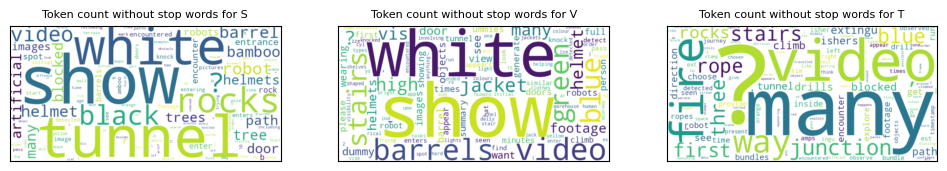

In [45]:
from transformers import GPT2Tokenizer
import re
import collections
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from analysis_utils import nostderr
with nostderr():
    import nltk
    from nltk.corpus import stopwords

df_queries = generate_df_queries() # dataframe with the queries participants made
df_queries.index.name = 'pid'
df_queries = df_queries.queries.dropna().reset_index()

with nostderr():
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
fig, axs = plt.subplots(1,3, figsize=(10,4))
fig.tight_layout()

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print(stop_words)

i = 0
for j, m in enumerate(['gallery', 'video', 'text']):
    string_list = df_queries[m].values
    extracted_texts = []
    for s in string_list:
        extracted_texts.extend(re.findall(r"text='(.*?)'", s))

    # Join all extracted texts into a single string
    combined_string = " ".join(extracted_texts)

    # Replace \n with a period followed by a space (if needed)
    cleaned_string = combined_string.replace('\n', '. ')

    # Correct the spacing around periods and single quotes
    cleaned_string = cleaned_string.replace(" .", ".")
    cleaned_string = cleaned_string.replace("  ", " ")

    tokens = tokenizer.tokenize(cleaned_string)
    clean_tokens = [token.replace('Ġ', '').lower() for token in tokens]

    if m == 'gallery':
        m = 'S'
    if m == 'video':
        m = 'V'
    if m == 'text':
        m = 'T'

    token_counts = collections.Counter(clean_tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(token_counts)
    filtered_tokens = [token for token in clean_tokens if token.lower() not in stop_words]
    token_counts = collections.Counter(filtered_tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(token_counts)
    axs[j].imshow(wordcloud, interpolation='bilinear')
    axs[j].get_xaxis().set_ticks([])
    axs[j].get_yaxis().set_ticks([])
    axs[j].set_title(f'Token count without stop words for {m}',  fontsize=8)
    

### Preference ranking

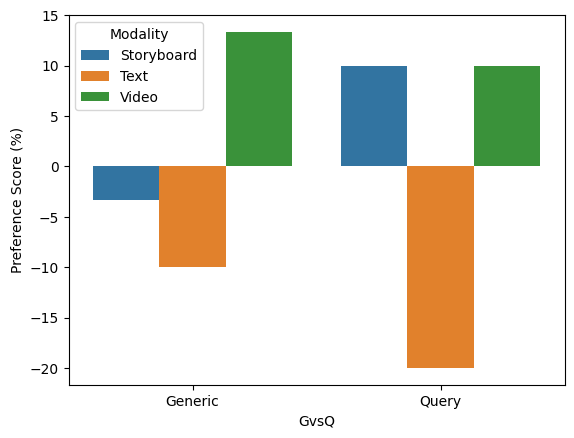

In [46]:
df_pref = original_df.preference.reset_index()

# Least Preferred Mode
contingency_table_least = pd.crosstab(df_pref['generic_or_query'], df_pref['least_prefer'])

# Most Preferred Mode
contingency_table_most = pd.crosstab(df_pref['generic_or_query'], df_pref['most_prefer'])

contingency_table_most.rename(columns={'Image Gallery': 'Gallery'}, inplace=True)
contingency_table_least.rename(columns={'Image Gallery': 'Gallery'}, inplace=True)

total_responses = contingency_table_most.sum().sum()
preference_scores = (contingency_table_most - contingency_table_least ) / total_responses *100
b = preference_scores.stack().reset_index().rename(columns={'most_prefer': 'Modality', 0:'Preference Score (%)', 'generic_or_query':'GvsQ'}).replace({'Gallery':'Storyboard'})

sns.barplot(data=b, y='Preference Score (%)', x='GvsQ', hue='Modality')
preference_scores = (contingency_table_most - contingency_table_least ) / total_responses *100


## Additional Analysis

Get the dataframe with model answers

In [57]:
df[['summary', 'correct']].groupby(['summary'], observed=False).mean()

,correct
summary,
No_Summary,0.433333
G,0.362963
Q,0.566667


In [47]:
df_model_answers = generate_model_answers_df()
columns = [
    (modality, object_or_event+str(qnum))
    for modality in modalities
    for object_or_event in ["object", "event"]
    for qnum in range(3)
]
df_all_answers = original_df
df_all_answers = df_all_answers[columns]
df_all_answers.columns.names = ["modality", "qname"]
df_all_answers = df_all_answers.stack(["modality", "qname"], future_stack=True)
df_all_answers.name = "user_answer"
df_all_answers = df_all_answers.to_frame()
answers.name = "answer"
df_all_answers = df_all_answers.join(answers, how="outer")  # answers index = ["modality", "qname"])
df_all_answers = df_all_answers.join(df_model_answers, how="left")  # model_df index = ["pid", "modality", "qname", "generic_or_query"]

df_all_answers[["answer", "user_answer", "model_answer"]]  # reorder nicely
df_all_answers = df_all_answers.reset_index()
df_all_answers

def compare_answers(row, answer_col_1, answer_col_2):
    if pd.isna(row[answer_col_1]) or pd.isna(row[answer_col_2]):
        return np.nan
    else:
        return 1 if row[answer_col_1] == row[answer_col_2] else 0

df_all_answers['correct_user_model'] = df_all_answers.apply(lambda row: compare_answers(row, 'user_answer', 'model_answer'), axis=1) # compare user vs model answers
df_all_answers['correct_user_GT'] = df_all_answers.apply(lambda row: compare_answers(row, 'user_answer', 'answer'), axis=1) # compare user vs GT answers
df_all_answers['correct_model_GT'] = df_all_answers.apply(lambda row: compare_answers(row, 'model_answer', 'answer'), axis=1) # compare model vs GT answers
df_all_answers 


# Get rid of control as no model involved and also those rows with no queries from users
df_all_answers_non_NaNs = pd.merge(df, df_all_answers)
df_all_answers_non_NaNs = df_all_answers_non_NaNs.dropna()
df_all_answers_non_NaNs 

# Sanity checks
# Cases where the model gave the wrong answer and the user the right
user_correct_despite = ((df_all_answers_non_NaNs.correct_user_GT == True) & (df_all_answers_non_NaNs.correct_model_GT == False))
df_all_answers_non_NaNs[user_correct_despite]

print(f'Mean accuracy GT2model {df_all_answers_non_NaNs.correct_model_GT.mean():.3f} * model2user {df_all_answers_non_NaNs.correct_user_model.mean():.3f} = {df_all_answers_non_NaNs.correct_model_GT.mean()*df_all_answers_non_NaNs.correct_user_model.mean():.3f} < Mean accuracy GT2user {df_all_answers_non_NaNs.correct_user_GT.mean():.3f}')


Mean accuracy GT2model 0.632 * model2user 0.622 = 0.393 < Mean accuracy GT2user 0.450


In [60]:
df_all_answers_non_NaNs.describe()
# df_all_answers_non_NaNs[['modality','generic_or_query','correct_model_GT', 'correct_user_model','correct_user_GT']].groupby(['modality','generic_or_query']).mean()
df_all_answers_non_NaNs[['correct_model_GT', 'correct_user_model','correct_user_GT']].mean()

correct_model_GT      0.631579
correct_user_model    0.621832
correct_user_GT       0.450292
dtype: float64